<a href="https://colab.research.google.com/github/bksat90/ImageSegmentation/blob/main/Image_Segmentation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installation of KerasCV.
!pip install -q --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.8 MB/s eta 0:00:00


In [2]:
# import libraries
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import keras
import keras_cv

from keras import layers
from keras_cv import bounding_box
from keras_cv import visualization
from random import shuffle
from PIL import Image
from pycocotools.coco import COCO

%matplotlib inline

Using TensorFlow backend


In [3]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Unzip the dataset file and store it in a folder called images.
!unzip "/content/drive/MyDrive/RMiDS/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/RMiDS/coco2017/"

Archive:  /content/drive/MyDrive/RMiDS/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001411.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/00000

In [5]:
# create required folders
os.chdir('/content/drive/MyDrive/RMiDS/coco2017/train-300')
os.mkdir('resized')
os.mkdir('masked')

os.chdir('/content/drive/MyDrive/RMiDS/coco2017/validation-300')
os.mkdir('resized')
os.mkdir('masked')

In [6]:
# Load paths for the COCO dataset annotation files
train_data_path = "/content/drive/MyDrive/RMiDS/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"
coco_train = COCO(train_annotation_file)

val_data_path = "/content/drive/MyDrive/RMiDS/coco2017/validation-300"
val_annotation_file = f"{train_data_path}/labels.json"
coco_val = COCO(val_annotation_file)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [7]:
def EDAbar(coco):
  """This function generates exploratory data analysis in bar chart
     coco - object for train or test data set
  """

  targets = ["cake", "car", "dog", "person"]
  # load the categories
  cIDs = coco.getCatIds(catNms=targets)
  cats = coco.loadCats(cIDs)

  # category names
  cat_names = [cat['name'].title() for cat in cats]

  # Get category counts
  cat_counts = [coco.getImgIds(catIds=[cat['id']]) for cat in cats]
  cat_counts = [len(img_ids) for img_ids in cat_counts]

  plt.figure()
  plt.bar(cat_names, cat_counts, align="center", color="blue")
  plt.xlabel('Count',fontsize=10)
  plt.ylabel('Categories',fontsize=10)
  plt.title('Categories in COCO Dataset',fontsize=10)

  plt.show()

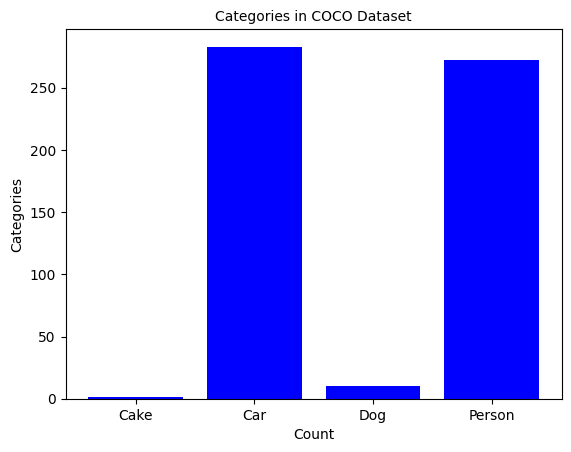

In [8]:
# EDA for training data set
EDAbar(coco_train)

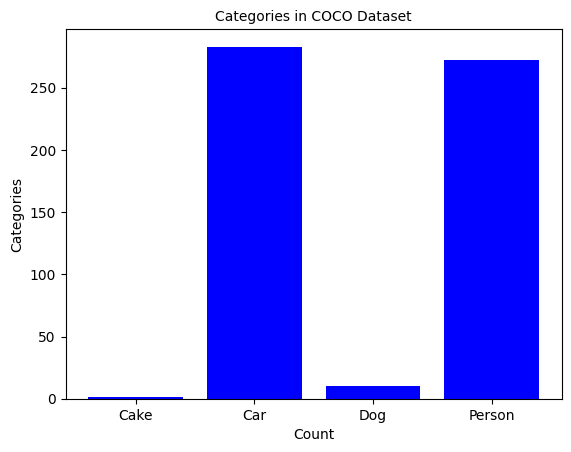

In [9]:
# EDA for training data set
EDAbar(coco_val)

In [10]:
target_classes = ["cake", "car", "dog", "person"]
catIds_train = []
imgDict_train = []
imgIds_train = []

catIds_val = []
imgDict_val = []
imgIds_val = []

# Iterate over each individual class in the list
for class_name in target_classes:
    # training data set
    temp1 = coco_train.getCatIds(catNms=class_name)
    catIds_train += temp1
    temp2  = coco_train.getImgIds(catIds=temp1)
    imgIds_train += temp2
    imgDict_train += coco_train.loadImgs(temp2)

    # test data set
    temp3 = coco_val.getCatIds(catNms=class_name)
    catIds_val += temp3
    temp4 = coco_val.getImgIds(catIds=temp3)
    imgIds_val += temp4
    imgDict_val += coco_val.loadImgs(temp4)

In [11]:
# Print the number of training and validation images and categories
print(len(imgIds_train), len(catIds_train))
print(len(imgIds_val), len(catIds_val))

566 4
566 4


In [12]:
# Shuffle the training and validation image IDs
shuffle(imgIds_train)
shuffle(imgIds_val)

In [13]:
# # Generate the list of file names for training and validation person images
# train_images_person = ["{0:012d}.jpg".format(id) for id in imgIds_train]
# val_images_person = ["{0:012d}.jpg".format(id) for id in imgIds_val]

In [14]:
# Print the number of training and validation person images
print(len(train_images_person), len(val_images_person))

566 566


In [15]:
# resize object
inf_resizing = keras_cv.layers.Resizing(640, 640,
                                              pad_to_aspect_ratio=True)

In [16]:
def imgresize(inf_resizing, srcfiles, srcdir, ttdir):
  """Resizes all images in the source folder and save them in target folder
  """
  for i in srcfiles:
    # # Set the file path for the mask
    srcfile = srcdir + i
    ttfile = ttdir + i
    img = keras.utils.load_img(srcfile)
    img = np.array(img)

    resized = inf_resizing([img])
    keras.utils.save_img(ttfile, resized[0])

In [17]:
# resize all training images
os.chdir("/content/drive/MyDrive/RMiDS/coco2017/train-300/data")
srcdir = '/content/drive/MyDrive/RMiDS/coco2017/train-300/data/'
ttdir = '/content/drive/MyDrive/RMiDS/coco2017/train-300/resized/'
srcfiles = os.listdir()

imgresize(inf_resizing, srcfiles, srcdir, ttdir)

In [18]:
# resize all validation images
os.chdir("/content/drive/MyDrive/RMiDS/coco2017/validation-300/data")
srcdir = '/content/drive/MyDrive/RMiDS/coco2017/validation-300/data/'
ttdir = '/content/drive/MyDrive/RMiDS/coco2017/validation-300/resized/'
srcfiles = os.listdir()

imgresize(inf_resizing, srcfiles, srcdir, ttdir)

In [21]:
# imgIds_train

[238,
 109,
 221,
 26,
 99,
 249,
 233,
 86,
 137,
 169,
 247,
 43,
 219,
 262,
 145,
 40,
 23,
 247,
 212,
 235,
 63,
 241,
 42,
 287,
 153,
 9,
 246,
 237,
 182,
 187,
 193,
 139,
 14,
 240,
 280,
 59,
 204,
 20,
 7,
 207,
 177,
 62,
 199,
 170,
 111,
 236,
 249,
 95,
 69,
 76,
 37,
 153,
 103,
 213,
 110,
 154,
 32,
 219,
 69,
 75,
 150,
 226,
 119,
 186,
 41,
 61,
 30,
 82,
 24,
 95,
 79,
 185,
 140,
 97,
 68,
 200,
 180,
 191,
 84,
 55,
 10,
 152,
 12,
 15,
 298,
 174,
 98,
 236,
 116,
 54,
 130,
 79,
 246,
 211,
 127,
 1,
 34,
 150,
 51,
 94,
 238,
 23,
 74,
 7,
 97,
 108,
 279,
 250,
 256,
 66,
 111,
 32,
 19,
 161,
 293,
 216,
 124,
 260,
 124,
 195,
 137,
 31,
 267,
 64,
 5,
 126,
 168,
 145,
 57,
 21,
 250,
 285,
 6,
 160,
 167,
 49,
 45,
 38,
 213,
 65,
 207,
 223,
 147,
 44,
 147,
 58,
 297,
 291,
 184,
 231,
 101,
 37,
 32,
 51,
 35,
 216,
 123,
 295,
 233,
 42,
 217,
 2,
 165,
 142,
 113,
 251,
 88,
 245,
 158,
 289,
 75,
 48,
 50,
 99,
 210,
 263,
 133,
 30,
 48,
 192,
 

In [23]:
# sampleImgIds = coco_train.getImgIds(imgIds=[3])
# sampleImgIds

[3]

In [24]:
# sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

In [30]:
# sampleImgDict

{'id': 3,
 'file_name': '000000000328.jpg',
 'height': 491,
 'width': 640,
 'license': None,
 'coco_url': None}

In [31]:
# sampleImgDict['file_name']

'000000000328.jpg'

In [27]:
# annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
# annIds

[32, 33, 34, 37]

In [28]:
# anns = coco_train.loadAnns(annIds)
# anns

[{'id': 32,
  'image_id': 3,
  'category_id': 41,
  'bbox': [44.81, 68.09, 223.8, 356.91],
  'segmentation': [[201.0,
    424.5,
    180.5,
    418.0,
    194.5,
    356.0,
    184.5,
    351.0,
    195.5,
    335.0,
    193.5,
    269.0,
    182.0,
    256.5,
    165.0,
    254.5,
    156.5,
    265.0,
    120.5,
    368.0,
    116.0,
    373.5,
    103.0,
    383.5,
    60.0,
    403.5,
    56.0,
    403.5,
    43.5,
    393.0,
    80.5,
    355.0,
    89.5,
    335.0,
    99.5,
    265.0,
    106.5,
    244.0,
    115.5,
    226.0,
    133.5,
    215.0,
    129.5,
    179.0,
    139.5,
    142.0,
    140.5,
    113.0,
    161.0,
    105.5,
    174.5,
    69.0,
    188.0,
    67.5,
    197.0,
    67.5,
    210.0,
    73.5,
    218.5,
    82.0,
    224.0,
    104.5,
    267.5,
    131.0,
    255.5,
    208.0,
    243.5,
    224.0,
    247.5,
    244.0,
    233.5,
    261.0,
    233.5,
    326.0,
    214.5,
    363.0,
    213.5,
    410.0,
    201.0,
    424.5]],
  'area': 79876.458000

In [ ]:
# for ID in imgIds_train:

#     # Retrieve a random image ID from the training set
#     sampleImgIds = coco_train.getImgIds(imgIds=[ID])
#     sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

#     # Retrieve the annotation IDs and annotations for the image
#     annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
#     anns = coco_train.loadAnns(annIds)

#     # Generate the mask by combining the individual instance masks
#     mask = coco_train.annToMask(anns[0])
#     for i in range(len(anns)):
#         mask = mask | coco_train.annToMask(anns[i])



#     # Convert the mask to an image and save it
#     mask = Image.fromarray(mask * 255, mode="L")
#     mask.save(file_path)
#     count = count + 1

In [20]:
# Generate the list of file names for training and validation person images
train_images_person = []
val_images_person = []

In [21]:
# Initialize a count variable
count = 0

# Generate the masks for training images
for ID in imgIds_train:

    # Retrieve a random image ID from the training set
    sampleImgIds = coco_train.getImgIds(imgIds=[ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve the annotation IDs and annotations for the image
    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    # Generate the mask by combining the individual instance masks
    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_train.annToMask(anns[i])

    train_images_person.append(sampleImgDict['file_name'])

    # Set the file path for the mask
    file_path = "/content/drive/MyDrive/RMiDS/coco2017/train-300/masked/" + sampleImgDict['file_name']

    # Convert the mask to an image and save it
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)
    count = count + 1

In [22]:
# Reset the count variable
count = 0

# Generate the masks for validation images
for ID in imgIds_val:

    # Retrieve a random image ID from the validation set
    sampleImgIds = coco_val.getImgIds(imgIds=[ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve the annotation IDs and annotations for the image
    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    # Generate the mask by combining the individual instance masks
    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    val_images_person.append(sampleImgDict['file_name'])
    # Set the file path for the mask
    file_path = "/content/drive/MyDrive/RMiDS/coco2017/validation-300/masked/" + sampleImgDict['file_name']

    # Convert the mask to an image and save it
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

    count = count + 1

In [25]:
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size):
        """CustomDataGenerator class for generating batches of preprocessed images and masks.
        """
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_filenames = self.get_matching_filenames()
        self.mask_filenames = self.get_matching_filenames()

    def get_matching_filenames(self):
        """Get the list of matching filenames between images and masks.
        """
        image_files = set([os.path.splitext(filename)[0] for filename in os.listdir(self.images_path)])
        mask_files = set([os.path.splitext(filename)[0] for filename in os.listdir(self.masks_path)])
        matching_files = list(image_files.intersection(mask_files))
        return matching_files

    def __len__(self):
        """Get the number of batches in the generator
        """
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        """Get a batch of preprocessed images and masks
        """
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for filename in batch_filenames:
            image_path = os.path.join(self.images_path, filename + '.jpg')
            mask_path = os.path.join(self.masks_path, filename + '.jpg')

            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Check if image and mask have the same dimensions
            if image.size != mask.size:
                raise ValueError(f"Incompatible dimensions for image {image_path} and mask {mask_path}")

            # Resize the images and masks to size 128x128
            image = image.resize((128, 128))
            mask = mask.resize((128, 128))

            # Convert the images and masks to arrays
            preprocessed_image = np.array(image)
            preprocessed_mask = np.array(mask)

            # Check if image has 3 channels and shape of (128, 128, 3)
            if len(preprocessed_image.shape) == 3 and preprocessed_image.shape == (128, 128, 3):
                # Normalize the pixel values if needed
                preprocessed_image = preprocessed_image / 255.0
                preprocessed_mask = preprocessed_mask / 255.0

                # Append the preprocessed images and masks to the batch
                batch_images.append(preprocessed_image)
                batch_masks.append(preprocessed_mask)

        # Convert the batch images and masks to numpy arrays and return
        return np.array(batch_images), np.array(batch_masks)

In [27]:
imgs_path = '/content/drive/MyDrive/RMiDS/coco2017/train-300/data'
msks_path = '/content/drive/MyDrive/RMiDS/coco2017/train-300/masked'
batch_size = 4

# Create an instance of the CustomDataGenerator
train_generator = CustomDataGenerator(imgs_path, msks_path, batch_size)

In [28]:
def validate_image_shapes(generator):
    """Print the shapes of preprocessed images generated by the provided generator.
    """
    for i in range(len(generator)):
        # Get a batch of preprocessed images from the generator
        batch_images, _ = generator[i]

validate_image_shapes(train_generator)

Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of pr